In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib
from matplotlib.ticker import MaxNLocator
set1 = sns.color_palette('Set1')
sns.set_palette('Set1')

import requests
from bs4 import BeautifulSoup

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
url = "https://www.worldometers.info/coronavirus/"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')


t = soup.find(id="main_table_countries_today").text

a = np.array(t.strip().split("\n"))

b = a[153:]

columns = ['Country', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', '', '', 'Continent']
df = pd.DataFrame(np.split(b, range(15, len(b), 15)), columns=columns).iloc[:212]

def convert_float(field):
    field = field.replace(',', '')
    try:
        return float(field)
    except ValueError:
        return None

for c in ['TotCases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']:
    df[c] = df[c].apply(convert_float)

for c in ['TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotalTests']:
    df[c] = df[c].apply(convert_float)
df.sort_values('TotalCases', ascending=False).head(20)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotCases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,,,Continent
174,Africa,1.350190e+11,NaN,NaN,89.0,NaN,NaN,1.160000e+02,NaN,30234.0,NaN,413.0,,"29,421",
152,Africa,4.102733e+09,NaN,NaN,265.0,NaN,NaN,1.010000e+02,NaN,63720.0,NaN,303.0,,"39,061",
8,145,2.827038e+08,203220.0,1.391124e+09,NaN,7769155.0,6.0,2.000000e-02,2141.0,NaN,NaN,3.0,Brazil,"14,446,541",
14,"545,768",8.508258e+07,NaN,1.821782e+06,NaN,NaN,5927.0,NaN,NaN,7.0,NaN,4409631.0,,"127,451",
36,"715,066",1.716602e+07,NaN,1.210041e+06,NaN,NaN,12830.0,NaN,NaN,22.0,NaN,1194989.0,,"24,065",
168,"27,230",1.503993e+07,NaN,3.949610e+08,NaN,NaN,74.0,NaN,NaN,112.0,NaN,36190.0,,614,
30,"1,812",1.096476e+07,328801.0,3.334770e+07,NaN,195523.0,NaN,NaN,796.0,NaN,NaN,18.0,Indonesia,"1,651,794",
80,"313,970",1.021410e+07,NaN,3.223063e+06,NaN,NaN,2732.0,NaN,NaN,52.0,NaN,314082.0,"+2,682","3,621",+22
58,"783,157",8.706538e+06,NaN,1.382210e+05,NaN,NaN,7082.0,NaN,NaN,37.0,NaN,612170.0,,"10,126",
196,Africa,6.317446e+06,NaN,NaN,31.0,NaN,NaN,1.310000e+02,NaN,18314.0,NaN,455.0,,"17,620",


In [3]:
hun_list = []
page_i = 0
while True:
    try:
        t = pd.read_html(f"https://koronavirus.gov.hu/elhunytak/?page={page_i}")[0]
        page_i += 1
        hun_list.append(t)
    except ValueError:
        break
hun = pd.concat(hun_list)
hun = hun.rename(columns={
   'Sorszám': 'id',
    'Nem': 'gender',
    'Kor': 'age',
    'Alapbetegségek': 'conditions'
})
hun = hun.drop('id', axis=1)

# Általános statisztikák

In [4]:
print("Összes elhunyt:", len(hun))
print("Átlagéletkor:", hun.age.mean().round(1))
print("Medián életkor:", hun.age.median())
print("Életkor szórása:", hun.age.std().round(1))
gc = hun.gender.value_counts()
print("Férfi: {}, Nő: {}".format(gc.loc['Férfi'], gc.loc['Nő']))

Összes elhunyt: 26984
Átlagéletkor: 74.1
Medián életkor: 76.0
Életkor szórása: 12.2
Férfi: 4330, Nő: 1524


In [5]:
daily_stats = pd.read_table("daily_stats.tsv", index_col="day", parse_dates=['day'])
today = pd.Timestamp.today()
if today.date() not in daily_stats.index:
    print("Adding today's stats")
    daily_stats.loc[today, "cnt"] = len(hun)
    daily_stats.loc[today, 'M'] = gc.loc['Férfi']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'M']
    daily_stats.loc[today, 'F'] = gc.loc['Nő']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'F']
    daily_stats.index = daily_stats.index.map(lambda i: i.date())
    
    headers = requests.utils.default_headers()
    headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
    url = "https://koronavirus.gov.hu/"
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    for d in soup.find_all("div", class_="diagram-a"):
        label = d.find("span", class_="label").get_text()
        number = d.find("span", class_="number")
        if number:
            number = number.get_text().replace(" ", "")
            daily_stats.loc[today.date(), label] = int(number)
    daily_stats.to_csv("daily_stats.tsv", sep="\t")
daily_stats = daily_stats.rename(columns={'Fertőzött': 'case', 'Gyógyult': 'recovered'})

Adding today's stats


In [6]:
lineplot_kws = dict(marker='X', linewidth=3, markersize=10)

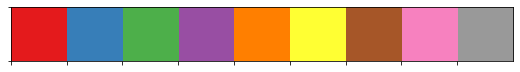

In [7]:
sns.palplot(sns.color_palette('Set1'))

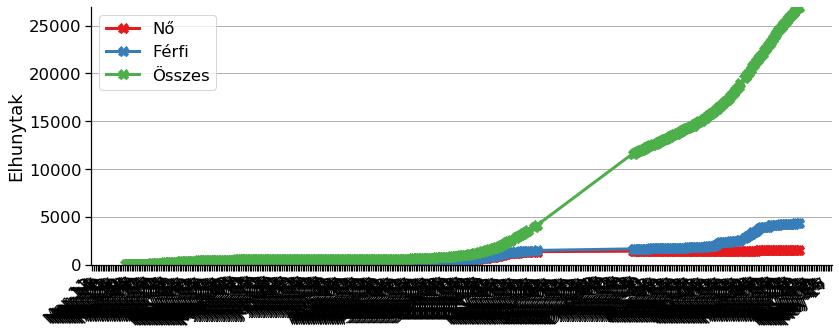

In [8]:
d = daily_stats.copy()
d = d.rename(columns={'M': 'Férfi', 'F': 'Nő', 'cnt': 'Összes'})
m = sns.color_palette('Set1')
cmap = [m[0], m[1], m[2]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Nő', 'Férfi', 'Összes'], color=cmap, ax=ax, **lineplot_kws)
    ax.set_ylim(0, len(hun)+5)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Elhunytak")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_death_count.png", dpi=200)

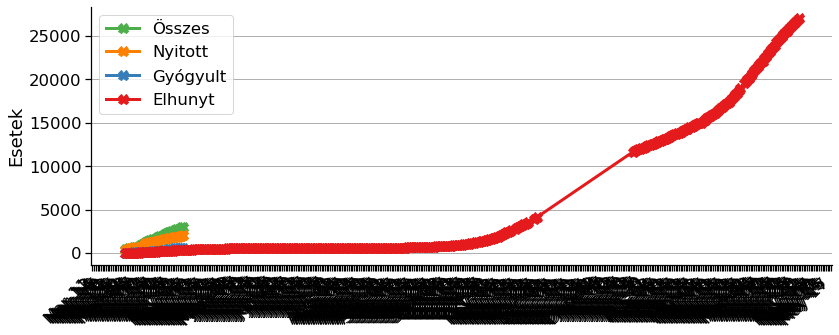

In [9]:
d = daily_stats.copy()
d = d.rename(columns={'recovered': 'Gyógyult', 'case': 'Összes', 'cnt': 'Elhunyt'})
d['Nyitott'] = d['Összes'] - d['Gyógyult'] - d['Elhunyt']
m = sns.color_palette('Set1')
cmap = [m[2], m[4], m[1], m[0]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Összes', 'Nyitott', 'Gyógyult', 'Elhunyt'], color=cmap, ax=ax, **lineplot_kws)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Esetek")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_all.png", dpi=200)

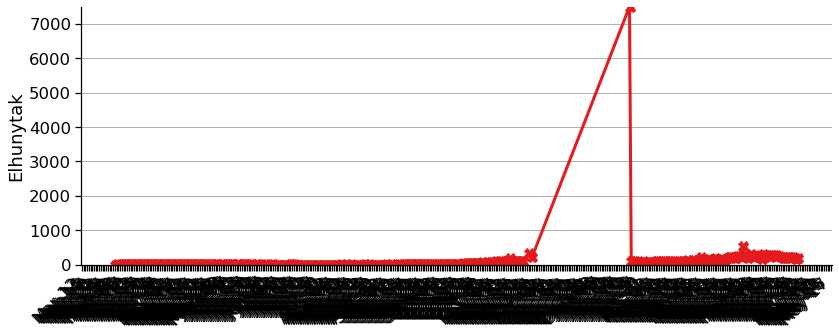

In [10]:
d = daily_stats.cnt.diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_new_deaths.png", dpi=200)

# Meggyógyult / elhunyt naponta

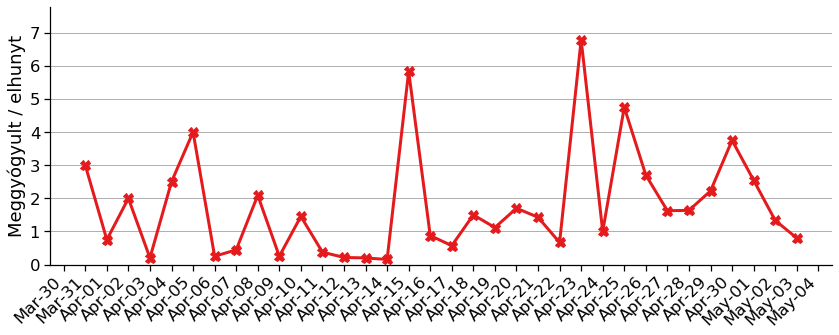

In [11]:
d = daily_stats[['cnt', 'recovered']].diff()
d['recovery/death'] = d['recovered'] / d['cnt']
d = d['recovery/death']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Meggyógyult / elhunyt")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_recovered_per_death.png", dpi=200)

In [12]:
daily_stats

,cnt,M,F,case,recovered,Hatósági házi karanténban,Mintavétel
day,,,,,,,
2020-03-30,15.0,NaN,NaN,447.0,34.0,NaN,NaN
2020-03-31,16.0,10.0,6.0,492.0,37.0,NaN,NaN
2020-04-01,20.0,12.0,8.0,525.0,40.0,NaN,NaN
2020-04-02,21.0,13.0,8.0,585.0,42.0,NaN,NaN
2020-04-03,26.0,16.0,11.0,623.0,43.0,NaN,NaN
...,...,...,...,...,...,...,...
2021-04-24,26208.0,4229.0,1515.0,NaN,NaN,NaN,NaN
2021-04-25,26420.0,4229.0,1515.0,NaN,NaN,NaN,NaN
2021-04-26,26625.0,4328.0,1515.0,NaN,NaN,NaN,NaN


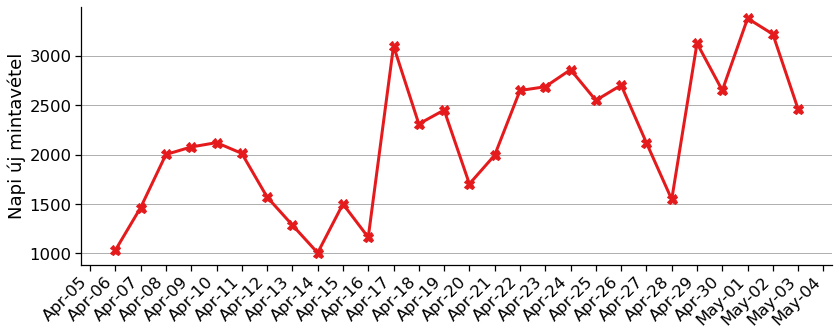

In [13]:
d = daily_stats['Mintavétel'].diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Napi új mintavétel")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_tests_per_day.png", dpi=200)

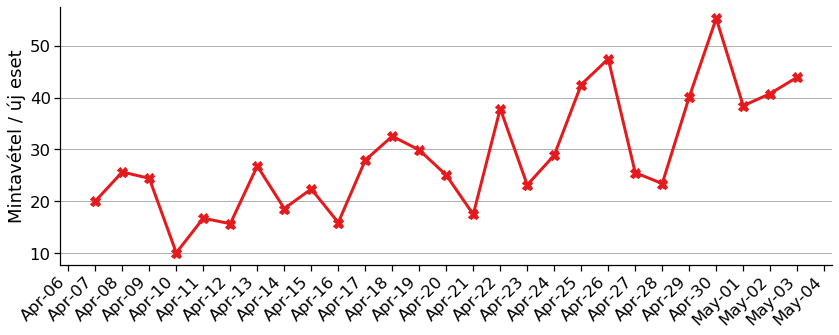

In [14]:
d = daily_stats[['case', 'Mintavétel']].diff()
d['Mintavétel/új eset'] = d['Mintavétel'] / d['case']
d = d['Mintavétel/új eset']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.dropna().iloc[1:].plot(ax=ax, **lineplot_kws)
    #ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Mintavétel / új eset")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_test_per_case.png", dpi=200)

# Korosztályonként

In [15]:
labels = ['40 alatt', '40-49', '50-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-90', '90 felett']
hun['age_group'] = pd.cut(hun.age, bins=[0, 39, 49, 59, 64, 69, 74, 79, 84, 89, 120], labels=labels)

In [16]:
barplot_kws = dict(alpha=0.8, color=sns.color_palette('Set1')[2], zorder=3)

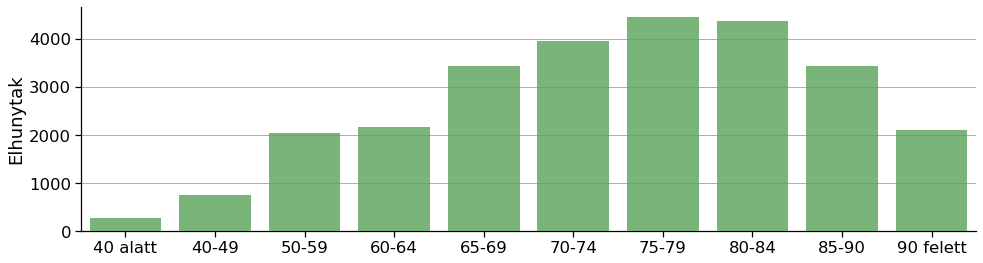

In [17]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    sns.countplot(hun.age_group, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    ax.grid(axis='y')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group.png", dpi=200)

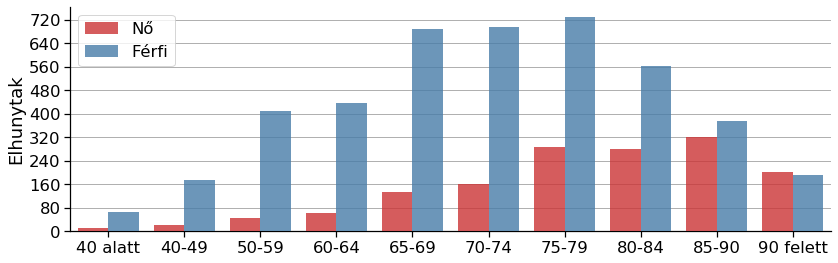

In [18]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    h = hun.groupby(['gender', 'age_group']).size().reset_index()
    h = h.rename(columns={0: 'cnt'})
    sns.barplot(x=h.age_group, y=h.cnt, hue=h.gender, ax=ax, hue_order=['Nő', 'Férfi'],
                palette=[set1[0], set1[1]], **barplot_kws)
    ax.legend(title="", loc='upper left', fancybox=True)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group_and_gender.png", dpi=200)

# Alapbetegségek

In [19]:
name_mapping = {}
with open("name_mapping.tsv") as f:
    for line in f:
        fd = line.strip().split("\t")
        name_mapping[fd[0]] = fd[1]

list_of_conditions = []
norm_map = {
    "anyagcsere és daganatos betegség": "anyagcsere betegség, daganatos betegség",
    "szív- és veseelégtelenség": "szívelégtelenség, veseelégtelenség",
}

def split_conditions(conditions):
    conditions = conditions.strip()
    cnt = 0
    if conditions in ("adat feltöltés alatt", "adatok feltöltése folyamatban", "adat feltöltése folyamatban", "nincs adat", "adatok feltöltés alatt"):
        return None
    conditions = conditions.replace("\xa0", " ")
    for src, tgt in norm_map.items():
        conditions = conditions.replace(src, tgt)
    for c in conditions.split(","):
        c = c.strip()
        if not c:
            continue
        c = name_mapping.get(c, c)
        list_of_conditions.append(c)
        cnt += 1
    return cnt
        
hun['condition_count'] = hun.conditions.apply(split_conditions)

lc = Counter(list_of_conditions)
conditions = pd.Series(lc)
conditions = conditions.reset_index().rename(columns={'index': 'condition', 0: 'cnt'})

categories = pd.read_table("categories.tsv", names=['condition', 'category'], skiprows=1)
all_cond = set(categories.condition.values)
for c in categories.category.unique():
    if c not in all_cond:
        categories = categories.append(pd.Series({'condition': c, 'category': c}), ignore_index=True)

conditions = conditions.merge(categories, on='condition', how='left')

# Alapbetegségek száma

Hány olyan elhunyt van, akinek 0, 1 vagy több alapbetegsége van.

In [20]:
cond_cnt = hun.condition_count.value_counts(dropna=False).sort_index()
cond_cnt['NA'] = cond_cnt.loc[np.nan]

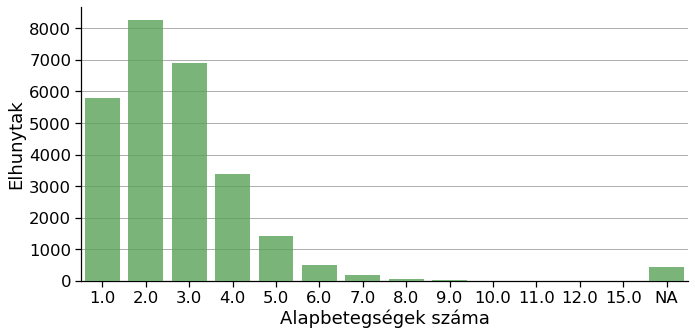

In [21]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    #sns.countplot(hun.condition_count, ax=ax, **barplot_kws)
    sns.barplot(x=cond_cnt.index, y=cond_cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("Alapbetegségek száma")
    sns.despine()
    ax.grid(axis='y', zorder=0)
    plt.tight_layout()
    fig.savefig("fig/condition_histogram.png", dpi=200)

# 10 leggyakoribb betegség

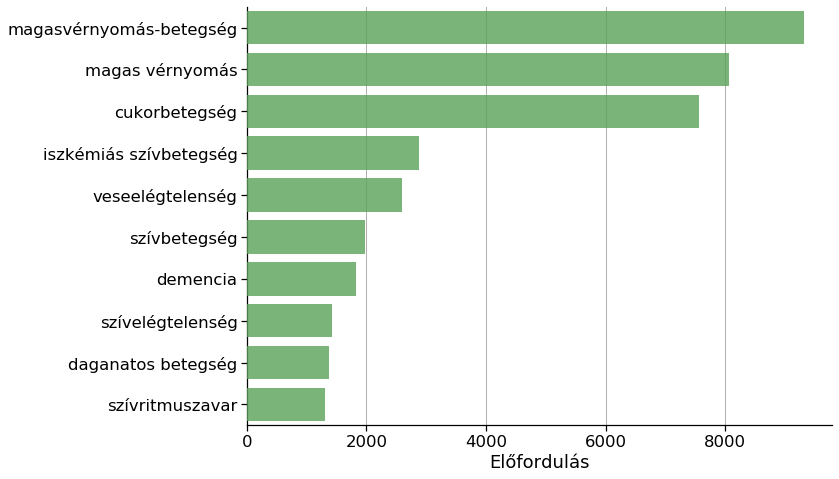

In [22]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.sort_values('cnt', ascending=False).head(10)
    sns.barplot(y=common.condition, x=common.cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.set_xlabel("Előfordulás")
    ax.grid(axis='x')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_most_common_diseases.png", dpi=200)

# Kategóriák

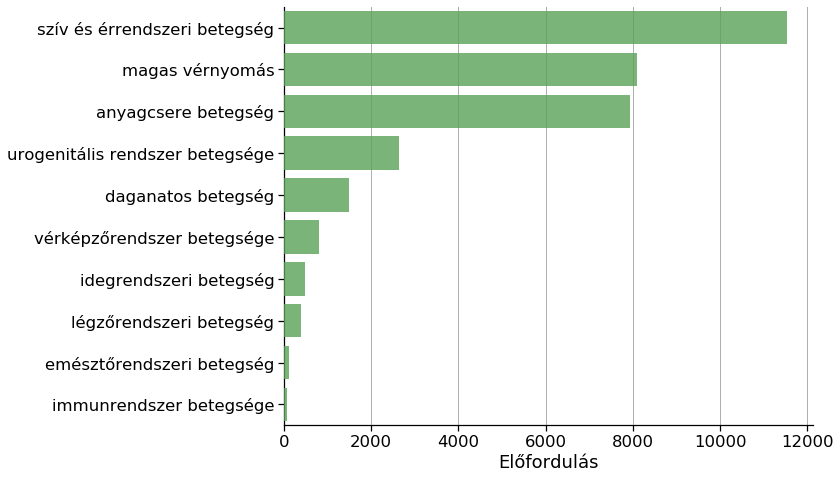

In [23]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.groupby('category')['cnt'].sum().sort_values(ascending=False).head(10)
    sns.barplot(y=common.index, x=common, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.grid(axis='x')
    ax.set_xlabel("Előfordulás")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_icd.png", dpi=200)

In [24]:
print("\n".join(conditions[conditions.category.isnull()].condition))

rosszindulatú daganatos megbetegedés
magasvérnyomás-betegség
agyi érkatasztrófa
depresszió
májbetegség
demencia
érszûkület
pangásos szívelégtelenség
krónikus veseelégetelenség
krónikus szívelégtelenség
elhízás
vastagbélgyulladás
szürkehályog
köszvény
sokízületi gyulladás
koszorúér-meszesedés
tüdõbetegség
Parkinson-kór
mitokondriális betegség
skizofrénia
vesebetegség
Alzheimer-kór
pajzsmirigy alulmûködés
nem ismert alapbetegség
kóros elhízás
hasnyálmirigy-daganat
egyéb vírusos tüdõgyulladás
hallucinációk
izomsorvadás
akut veseelégtelenség
agyi érelmeszesedés
csontvelõ rendellenességei
refluxbetegség
pajzsmirigy alulmûködése
beültetett pacemaker
paranoid skizofrénia
gyógyszer okozta májbetegség
mûbillentyû a szívben
szívizom vérellátási elégtelensége
agysorvadás
iszkémiás agyi érkatasztrófa
pajzsmirigy-betegség
agyi- és általános érelmeszesedés
szív- és érrendszeri betegségek
fekélyes vastagbélgyulladás
toxikus májbetegség
krónikus hasnyálmirigy-gyulladás
vérképzési zavar
végbél tályog
a